# Speaker-Independent Spoken Digit Recognition (xSDR)


One of the successful stories of deep neural networks is the proliferation of commercial of automatic speech recognition (ASR) systems. This project aims to explore one application of ML-powered ASR to the problem of spoken digit recognition (SDR). Since digits are widely used as unique identifiers for bank information, social security numbers, post codes, etc, SDR systems can be an efficient alternative to fully-fledged ASR systems since the domain is more predictable than other applications of ASR. 

In this project, we focus on developing a SDR system in a speaker-independent setting. That is, the speakers in the evaluation set are disjoint from the training set speakers. We do so because we expect real-world ASR systems to generalize to different speakers than those we have data for. Moreover, for many languages that are under-resourced, we have have (limited) annotated speech data from a single speaker, but we would still want the system to be deployed to work on any speaker of that language. We tackle the problem of spoken digit recognition as a sequence classification task. Concretely, the inputs are short audio clips of a specific digit (in the range 0-9), then the goal is to build deep neural network models to classify a short audio clip and predict the digit that was spoken.

In [ ]:
%matplotlib inline
import sys
import numpy as np
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

import pandas as pd
from scipy import stats

from sklearn  import preprocessing
import skimage

from collections import defaultdict, Counter

# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')

import random
import tqdm

In [ ]:
# for linear models 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T

## Exploring the Dataset 

The speech samples are already divied into training, development, and test spilts. The splits are made in such way that evaluation speakers are not present in training split. You should use the splits as they are. 

**CAUTION:** 

In this project, you are not allowed to use any external data for this problem (at least for the main three tasks). Exploring the effect of additional datasets in this project can only included as a further step after completing the main requirements with the given data. 

In [ ]:
# read tsv file into a dataframe 
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

In [ ]:
sdr_df.head()

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,speech_data/5_theo_23.wav
1,2_yweweler_39,yweweler,TEST,2,speech_data/2_yweweler_39.wav
2,6_yweweler_34,yweweler,DEV,6,speech_data/6_yweweler_34.wav
3,6_yweweler_16,yweweler,DEV,6,speech_data/6_yweweler_16.wav
4,9_yweweler_2,yweweler,TEST,9,speech_data/9_yweweler_2.wav


In [ ]:
set(sdr_df.speaker.values)

{'george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'}

In [ ]:
# explore one sample: 7_theo_0
sdr_df.loc[sdr_df['identifier'] == '7_theo_0']

,identifier,speaker,split,label,file
700,7_theo_0,theo,TRAIN,7,speech_data/7_theo_0.wav


In [ ]:
sample_wav_file = sdr_df.loc[sdr_df['identifier'] == '7_theo_0'].file[700]

## The Speech Waveform

The acoustic realization of speech segment can be (digitally) viewed as a time-variant wavform $\mathbf{S} \in \mathbb{R}^{n}$. Here, $n$ depends on both the duration of the speech segment and the sampling rate of the continous speech singal. Let's check out one sample from the data set. 

In [ ]:
# play and listen to a sample 
SAMPLING_RATE = 8000 # This value is determined by the wav file, DO NOT CHANGE

x, sr = librosa.load(sample_wav_file, sr=SAMPLING_RATE) #, 
ipd.Audio(x, rate=sr)

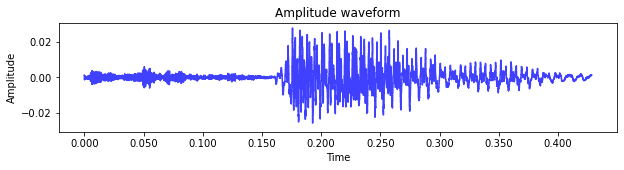

In [ ]:
# plot as a waveform 
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.waveshow(y=x, sr=sr, alpha=0.75, x_axis='time', color='blue')

ax.set(title='Amplitude waveform')
ax.set_ylabel('Amplitude')
ax.label_outer()

In [ ]:
# sample duration in milliseconds
(1000*len(x))/SAMPLING_RATE

428.5

In the cell above, you can see the temporal duration of the audio is 428.5 milliseconds. For digits in the range 0-9, the duration of the speech segment should be around 0.5 seconds with reasonable variation depending on speech rate (i.e., how fast the speaker speaks). 

## The Speech Signal Representation - Mel Spectrograms

Humans can recognize and differentiate different speech sounds based on the frequency characteristics of the sounds. For machine learning applications, human speech is represented using spectro-temporal features in the [Mel-scale](https://en.wikipedia.org/wiki/Mel_scale) extracted from the speech sample. Mel-scale features are inspired by human speech perception and auditory processing whereby the human ear has difference sensitivity (or resolution) in differet frequency bandes. That is, the human ear can better recognize differences in in lower range frequences, while higher range frequences have a lower resolution. The Mel-scale is linear for frequencies in the range (0-1kHz), and logarithmic for frequencies above 1kHz.

In the spectro-temporal representation of speech, a speech sample can be seen as a sequence of $T$ spectral vectors as $\mathbf{X} = (\mathbf{x}^1, \mathbf{x}^2, \dots, \mathbf{x}^T)$. Each spectral vector $\mathbf{x}^t \in \mathbb{R}^{k}$ at time-step $t$ is extracted from a short speech segment (~25 milliseconds) with the assumption that the signal is time-invariant in this small time window. Here, $k$ is the number of frequency bands in the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) and this is a parameter of the feature extraction pipeline. The representation is based on the Fourier transform to convert the temporal signal into the frequency domain. 

In automatic speech recognition (ASR) research and applications, spectral vectors are usually referred to as "acoustic frames". Morover, adjacent frames are extracted with some overlap between them, usually ~10 milliseconds. 

In [ ]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr), 
    and the number of mel coefficients, return a mel-scaled 
    representation of the signal as numpy array.
    """
    
    mel_features = librosa.feature.melspectrogram(y=signal,
        sr=sr,
        n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
        hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
        n_mels=num_mels, # number of frequency bins, use either 13 or 39
        fmin=50, # min frequency threshold
        fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
    )
    
    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)
    
    return scaled_log_mel_features

In [ ]:
melspectrogram = extract_melspectrogram(x, sr, num_mels=13)

melspectrogram.shape

(13, 43)

Note that the shape of the array (K x T) represents the number of frequency bands (K) and the number of spectral vectors in this representation (here, K=13, T=43). K is a hyperparameter and the recommended values in ASR research are (13, 39, 81, etc). Here, we fix K = 13. On the other hand, T varies from sample to sample depending on the duration of the sample.  

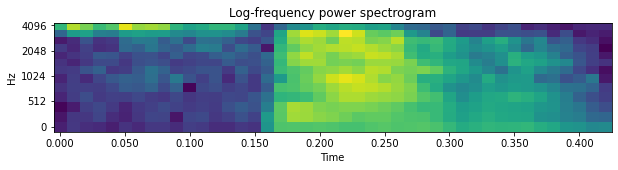

In [ ]:
# plot and view the spectrogram

fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.specshow(
    melspectrogram, 
    sr=sr, 
    x_axis='time', 
    y_axis='mel', 
    cmap='viridis', 
    fmax=4000, 
    hop_length=80
)

ax.set(title='Log-frequency power spectrogram')

ax.label_outer()

In [ ]:
def plot_classification_report(test_label, test_pred, title='Classification report'):
    cm = confusion_matrix(test_label, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()
    print(classification_report(test_label, test_pred))

As you can see above from the figure, the spectrogram representation can be viewed as a matrix $\mathbf{X} \in \mathbb{R}^{T} \times \mathbb{R}^{k}$.  

## Task I
1. One problem with the spectrogram as a speech feature represetation is that different speech samples would have dfferent durations due to inherent speech variability (e.g., speech rate, speaker dialect, etc). That is, the $T$ in the $(T \times k)$-dimensional representation would be different for each sample. Therefore, for the baseline model, we will implement a method to have a fixed-size representation for all speech samples. Write a function downsample_spectrogram(X, N) that takes as input a spectrogram $\mathbf{X} \in \mathbb{R}^{T \times k}$ and a parameter N <= 25. The function should (1) make N equally-sized splits of S across the time-axis, (2) apply a pooling technique (e.g., mean pooling) to each split across the frequency axis to obtain an array that represents a downsampled version of the spectrogram $\mathbf{X}' \in \mathbb{R}^{N \times k}$, and (3) re-arange $\mathbf{X}'$ as a vector $\mathbf{v} \in \mathbb{R}^{Nk}$.    

2. Using the downsample_spectrogram(X, N) function, transform all the speech samples into vectors $\mathbf{v} \in \mathbb{R}^{Nk}$. 

3. Given the speaker-based train/dev/test spilts in the SDR_metadata.tsv, fit a linear model on the training samples. That is, your model should be build on data from 4 speakers {'nicolas', 'theo' , 'jackson',  'george'}. Hint: you can experiment with a few model alternatives in the SGDClassifier module in scikit-learn. 

4. Evaluate you model on the dev and test splits. Use accuracy as an evaluation metric. Analyze the model performance using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of the all possible labels (0-9), Analyze [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall), [F1-score](https://en.wikipedia.org/wiki/F-score) for each label. Report your observation.

In [ ]:
def downsample_spectrogram(X, N):
    """
    Given a spectrogram of an arbitrary length/duration (X ∈ K x T), 
    return a downsampled version of the spectrogram v ∈ K * N
    """
    stride_val = int(X.shape[1]/N)
    v = skimage.measure.block_reduce(X[:, :stride_val * N], (1, stride_val), np.mean).flatten()
    return v

## Baseline Model

In [ ]:
def x_y_dataset(sdr_df, split_name, N):
    x_arr = np.empty((0, 13*N))
    y_arr = np.empty(0, dtype=np.int)
    num_small_files = 0
    for i in sdr_df.loc[sdr_df['split'] == split_name].index:
        wav_file = sdr_df.loc[sdr_df['split'] == split_name].file[i]
        x, sr = librosa.load(wav_file, sr=SAMPLING_RATE) #,
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
        if melspectrogram.shape[1] < N: 
            melspectrogram = np.pad(array           = melspectrogram, 
                                    pad_width       = [(0, 0), (0, N - melspectrogram.shape[1])], 
                                    mode            = 'constant', 
                                    constant_values = (0,))
            num_small_files = num_small_files + 1  
        x_arr = np.vstack((x_arr, downsample_spectrogram(melspectrogram, N)))
        y_arr = np.append(y_arr, sdr_df.loc[sdr_df['split'] == split_name].label[i])

    print("Number of files with less than " + str(N) + " spectral vectors for the dataset " + split_name + " are " + str(num_small_files))
    return x_arr, y_arr

In [ ]:
N = 21

# prepare data and split 
x_train, y_train = x_y_dataset(sdr_df, 'TRAIN', N)
x_dev,   y_dev   = x_y_dataset(sdr_df, 'DEV',   N)
x_test,  y_test  = x_y_dataset(sdr_df, 'TEST',  N)

Number of files with less than 21 spectral vectors for the dataset TRAIN are 27
Number of files with less than 21 spectral vectors for the dataset DEV are 8
Number of files with less than 21 spectral vectors for the dataset TEST are 7


In [ ]:
# train a linear model 
clf_sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=10).fit(x_train, y_train)
train_pred_sgd = clf_sgd.predict(x_train)
test_pred_sgd = clf_sgd.predict(x_test)

print("For a value of N =", N)
print("Train Accuracy of SGD:", accuracy_score(np.array(y_train), np.array(train_pred_sgd)))
print("Test Accuracy of SGD:", accuracy_score(np.array(y_test), np.array(test_pred_sgd)))

For a value of N = 21
Train Accuracy of SGD: 0.888
Test Accuracy of SGD: 0.4194831013916501


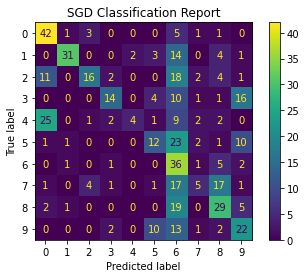

              precision    recall  f1-score   support

           0       0.51      0.79      0.62        53
           1       0.89      0.56      0.69        55
           2       0.67      0.30      0.41        54
           3       0.64      0.30      0.41        46
           4       0.67      0.09      0.15        46
           5       0.39      0.24      0.30        50
           6       0.22      0.78      0.34        46
           7       0.33      0.11      0.16        47
           8       0.44      0.52      0.48        56
           9       0.38      0.44      0.41        50

    accuracy                           0.42       503
   macro avg       0.51      0.41      0.40       503
weighted avg       0.52      0.42      0.41       503



In [ ]:
plot_classification_report(y_test, test_pred_sgd, 'SGD Classification Report')

**Baseline Model**: Using SGD Classifier we get around 43.7% accuracy on the test set. Also, looking at the train set accuracy we see it has already reached 88.6%. For identifying best value of parameter N for downsampling function we see that most values of N gave similar results and went ahead with a value of 21.

Looking at inidvidual class precision we see class 5 gets a perfect precision. This is also visible from the confusion matrix where we see there isn't a case where we predict 5 and it is wrong. But this does not mean overall 5 is always predicted perfectly. As 5 has a rather bad recall value. This means samples with label 5 are often predicted badly. 

We don't see an abnormally high recall score with a very low precision value.

Overall, looking at the F1 score we see class 0 and 1 give the best performance.

In [ ]:
# Further train a MLP model ot baseline a neural network
clf_mlp = MLPClassifier(hidden_layer_sizes=(100,1000,100), random_state=1, max_iter=5000).fit(x_train, y_train)
train_pred_mlp = clf_mlp.predict(x_train)
test_pred_mlp = clf_mlp.predict(x_test)

print("For a value of N =", N)
print("Train Accuracy of MLP:", accuracy_score(np.array(y_train), np.array(train_pred_mlp)))
print("Test Accuracy of MLP:", accuracy_score(np.array(y_test), np.array(test_pred_mlp)))

For a value of N = 21
Train Accuracy of MLP: 1.0
Test Accuracy of MLP: 0.5407554671968191


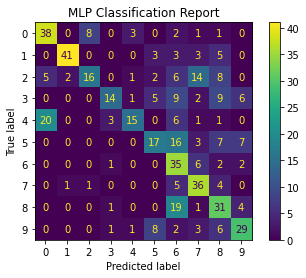

              precision    recall  f1-score   support

           0       0.60      0.72      0.66        53
           1       0.93      0.75      0.83        55
           2       0.64      0.30      0.41        54
           3       0.70      0.30      0.42        46
           4       0.71      0.33      0.45        46
           5       0.49      0.34      0.40        50
           6       0.34      0.76      0.47        46
           7       0.51      0.77      0.62        47
           8       0.42      0.55      0.48        56
           9       0.60      0.58      0.59        50

    accuracy                           0.54       503
   macro avg       0.60      0.54      0.53       503
weighted avg       0.60      0.54      0.53       503



In [ ]:
plot_classification_report(y_test, test_pred_mlp, 'MLP Classification Report')

**Baseline MLP Model:** We have created a MLP model to compare our later more complex NN models. Using MLP Classifier we get around 54% accuracy on the test set. Also, looking at the train set accuracy we see it has hugely overfitted and got 100%. We tried various different layer configuration but this seems to work best.

We don't see an abnormally high recall or precision score for a very low precision or recall value respectively.

Overall, looking at the F1 score we see class 0, 1 and 9 give the best performance.

## Task II
1. Having established a baseline with a linear model trained on a downsampled signal representation of the speech segment, this task aims to learn a classifier based on the full speech segment. To this end, you will implement a neural model that is suitable for sequential data such as recurrent DNN, convolutional DNN with 1-D temporal convolution, or an audio transformer. The model should take the acoustic sample as it is (i.e., the Mel spectrogram could have an arbitrary length) without the need to downsample the segment. You need to implement at least two of the aforementioned models. Do the neural models improve accuracy over the baseline model? Do you observe any signs of overfitting to the training data? How do the hyperparameters affect the model performance? Report and discuss your observations.        

2. Evaluate your (best) neural models and compare to the baseline model using the same evalution process as in task I.4. 

3. Use a dimensionality reduction algorithm such as t-SNE \[[1](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding),[2](https://pypi.org/project/tsne-torch/),[3](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)\] or [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) to analyze how the different models seperate the different classes (the last non-linear layer in your model). Compare to the downsampled representation you used in the baseline and report your observations.

4. Are the differences between the different models statistically significant? To answer this question, you need to implement a statistical significance test based on bootstrapping method. To read more how to estiame p-values based on bootstrapping, we recommend the materials on this paper https://aclanthology.org/D12-1091.pdf. Include the baseline model in your evaluation. 

In [ ]:
class SDRDataset(Dataset):

  def __init__(self, sdr_df, dataset_type, indices=None):
    self.files  = sdr_df.file[sdr_df.split == dataset_type].to_numpy()
    self.labels = sdr_df.label[sdr_df.split == dataset_type].to_numpy()
    if indices is not None:
      self.files = self.files[indices]
      self.labels = self.labels[indices]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    x, sr = librosa.load(self.files[idx], sr=SAMPLING_RATE)
    melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
    # return (melspectrogram.transpose(1, 0), melspectrogram.shape[1], self.labels[idx])
    return (melspectrogram.transpose(1, 0), self.labels[idx])

In [ ]:
# Create dataset instances for train/dev/test set
train_ds = SDRDataset(sdr_df, 'TRAIN')
dev_ds   = SDRDataset(sdr_df, 'DEV')
test_ds  = SDRDataset(sdr_df, 'TEST')

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
dev_dl   = DataLoader(dev_ds,   batch_size=1, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=1, shuffle=False)

For dataset we are using melspectrogram extracted from the `extract_melspectrogram` function. Then we create a pytorch dataset using this extracted melspectrogram

In [ ]:
def train(model, train_dl, val_dl, criterion, optimizer, epochs=5, early_stop=True, patience=5, checkpoint_name="checkpoint.pt"):
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        epoch_loss = []
        for i, (mel, label) in enumerate(train_dl):
            mel, label = mel.to(device), label.to(device)
            
            outputs = model(mel)
            loss = criterion(outputs, label)

            epoch_loss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss_mean = sum(epoch_loss)/len(epoch_loss)

        preds, labs = predict_dl(model, val_dl)
        acc = accuracy_score(preds, labs)
        
        if acc > best_val_acc:
            best_val_acc = acc
            torch.save(model.state_dict(), checkpoint_name)
        
        print("Epoch [{}/{}] Loss: {:.4f} Val. Acc: {:.4f} Best Model Acc: {:.4f}".format(epoch+1, epochs, epoch_loss_mean, acc, best_val_acc))

In [ ]:
def predict_dl(model, dataloader):
    preds, labels = [], []
    model.eval()
    for (mel, label) in dataloader:
        mel, label = mel.to(device), label.to(device)
        preds.extend(torch.argmax(model(mel), dim=1).tolist())
        labels.extend(label.tolist())
    return preds, labels

In [ ]:
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


##### RNN

In [ ]:
class RNNModel(nn.Module):

  def __init__(self, input_size, hidden_dim, output_size=10, n_layers=1):
    super(RNNModel, self).__init__()
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    self.lstm = nn.LSTM(input_size, hidden_dim)
    self.fc = nn.Linear(hidden_dim, output_size)

  def forward(self, x, hid_prev=None, ctx_prev=None):
    batch_size = x.size(0)
    hidden, context = self.init_hidden(batch_size, x)
    out, (hid, ctx) = self.lstm(x, (hidden, context))
    out = self.fc(out)
    out = torch.mean(out, dim=1)
    out = F.softmax(out, dim=-1)
    return out

  def init_hidden(self, batch_size, x):
    hidden  = torch.zeros(self.n_layers, x.shape[1], self.hidden_dim).to(device)
    context = torch.zeros(self.n_layers, x.shape[1], self.hidden_dim).to(device)
    return hidden, context

In [ ]:
# Instantiate the model with hyperparameters
rnn_model = RNNModel(input_size=13, hidden_dim=256, output_size=10).to(device)

# Define hyperparameters
n_epochs = 30
lr = 0.001

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [ ]:
# train the model
train(model=rnn_model, train_dl=train_dl, val_dl=dev_dl, criterion=criterion, optimizer=optimizer, epochs=n_epochs, checkpoint_name="rnn_full.pt")

Epoch [1/30] Loss: 2.1435 Val. Acc: 0.4306 Best Model Acc: 0.4306
Epoch [2/30] Loss: 1.8319 Val. Acc: 0.3863 Best Model Acc: 0.4306
Epoch [3/30] Loss: 1.7170 Val. Acc: 0.4105 Best Model Acc: 0.4306
Epoch [4/30] Loss: 1.6610 Val. Acc: 0.3883 Best Model Acc: 0.4306
Epoch [5/30] Loss: 1.6218 Val. Acc: 0.4245 Best Model Acc: 0.4306
Epoch [6/30] Loss: 1.5971 Val. Acc: 0.5231 Best Model Acc: 0.5231
Epoch [7/30] Loss: 1.5798 Val. Acc: 0.4608 Best Model Acc: 0.5231
Epoch [8/30] Loss: 1.5644 Val. Acc: 0.4427 Best Model Acc: 0.5231
Epoch [9/30] Loss: 1.5549 Val. Acc: 0.5070 Best Model Acc: 0.5231
Epoch [10/30] Loss: 1.5468 Val. Acc: 0.4950 Best Model Acc: 0.5231
Epoch [11/30] Loss: 1.5384 Val. Acc: 0.4869 Best Model Acc: 0.5231
Epoch [12/30] Loss: 1.5324 Val. Acc: 0.5091 Best Model Acc: 0.5231
Epoch [13/30] Loss: 1.5268 Val. Acc: 0.5352 Best Model Acc: 0.5352
Epoch [14/30] Loss: 1.5216 Val. Acc: 0.5332 Best Model Acc: 0.5352
Epoch [15/30] Loss: 1.5187 Val. Acc: 0.5272 Best Model Acc: 0.5352
Epoc

In [ ]:
# Load the best model from the checkpoint saved by early stopping
rnn_model.load_state_dict(torch.load('rnn_full_best.pt', map_location=device))

# Evaluate on train & test set
train_pred_rnn, train_labs = predict_dl(rnn_model, train_dl)
test_pred_rnn, test_labs = predict_dl(rnn_model, test_dl)

print("Train Accuracy of RNN: ", accuracy_score(np.array(train_labs), np.array(train_pred_rnn)))
print("Test Accuracy of RNN: ", accuracy_score(np.array(test_labs), np.array(test_pred_rnn)))

Train Accuracy of RNN:  0.982
Test Accuracy of RNN:  0.5924453280318092


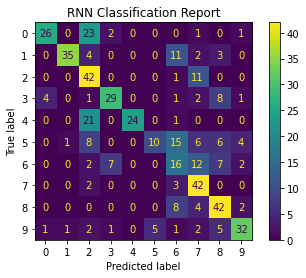

              precision    recall  f1-score   support

           0       0.84      0.49      0.62        53
           1       0.95      0.64      0.76        55
           2       0.40      0.78      0.53        54
           3       0.74      0.63      0.68        46
           4       1.00      0.52      0.69        46
           5       0.67      0.20      0.31        50
           6       0.28      0.35      0.31        46
           7       0.51      0.89      0.65        47
           8       0.59      0.75      0.66        56
           9       0.76      0.64      0.70        50

    accuracy                           0.59       503
   macro avg       0.67      0.59      0.59       503
weighted avg       0.68      0.59      0.59       503



In [ ]:
plot_classification_report(test_labs, test_pred_rnn, 'RNN Classification Report')

**RNN Model:** We first start by creating a RNN model to improve our classifier. Using MLP Classifier we get around 59.2% accuracy on the test set. Also, looking at the train set accuracy we see it has hugely overfitted and got 98.2%. We see this a small increase from the previous MLP baseline model we created.

Looking at inidvidual class precision we see class 4 gets a perfect precision. This is also visible from the confusion matrix where we see there isn't a case where we predict 4 and it is wrong prediction. But this does not mean overall 4 is always predicted perfectly. As 4 has a rather bad recall value. This means samples with label 4 are often predicted badly. 

Further Looking at inidvidual class recall we see class 7 gets the highest precision. This is also visible from the confusion matrix where we see samples belonging to class 7 are predicted correctly. But this does not mean overall 7 is always predicted perfectly. As 7 has a rather bad precision value. This means many samples with different label values are often predicted as belonging to class 7. 

Overall, looking at the F1 score we see class 0, 1, 3, 4, 7, 8 and 9 give a good and comparable performance.

##### CNN

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, n_input=1, n_output=10, stride=2, n_channel=8):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=1, stride=stride)
        self.dropout1 = nn.Dropout(p=0.1)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.conv2 = nn.Conv1d(n_channel, 2*n_channel, kernel_size=3, padding='same')
        self.dropout2 = nn.Dropout(p=0.1)
        self.bn2 = nn.BatchNorm1d(2*n_channel)
        self.conv3 = nn.Conv1d(2*n_channel, 3 * n_channel, kernel_size=3, padding='same')
        self.dropout3 = nn.Dropout(p=0.1)
        self.bn3 = nn.BatchNorm1d(3 * n_channel)
        self.conv4 = nn.Conv1d(3 * n_channel, 3 * n_channel, kernel_size=3, padding='same')
        self.dropout4 = nn.Dropout(p=0.2)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.fc1 = nn.Linear(3 * n_channel, n_output)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        x = self.conv1(x)
        # x = self.dropout1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        # x = self.dropout2(x)
        x = F.relu(self.bn2(x))
        x = self.conv3(x)
        # x = self.dropout3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        # x = self.dropout4(x)
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = torch.mean(x, dim=1)
        return F.softmax(x, dim=-1)

In [ ]:
cnn_model = CNNModel(n_input=13, n_output=10)
cnn_model.to(device)
print(cnn_model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

CNNModel(
  (conv1): Conv1d(13, 8, kernel_size=(1,), stride=(2,))
  (dropout1): Dropout(p=0.1, inplace=False)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=same)
  (dropout2): Dropout(p=0.1, inplace=False)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(16, 24, kernel_size=(3,), stride=(1,), padding=same)
  (dropout3): Dropout(p=0.1, inplace=False)
  (bn3): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=same)
  (dropout4): Dropout(p=0.2, inplace=False)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=10, bias=True)
)


In [ ]:
train(model=cnn_model, train_dl=train_dl, val_dl=dev_dl, criterion=criterion, optimizer=optimizer, epochs=n_epochs, checkpoint_name="cnn_full.pt")

Epoch [1/30] Loss: 2.1310 Val. Acc: 0.4406 Best Model Acc: 0.4406
Epoch [2/30] Loss: 1.8394 Val. Acc: 0.4970 Best Model Acc: 0.4970
Epoch [3/30] Loss: 1.7385 Val. Acc: 0.5594 Best Model Acc: 0.5594
Epoch [4/30] Loss: 1.6789 Val. Acc: 0.4386 Best Model Acc: 0.5594
Epoch [5/30] Loss: 1.6518 Val. Acc: 0.5614 Best Model Acc: 0.5614
Epoch [6/30] Loss: 1.6263 Val. Acc: 0.5875 Best Model Acc: 0.5875
Epoch [7/30] Loss: 1.6090 Val. Acc: 0.6258 Best Model Acc: 0.6258
Epoch [8/30] Loss: 1.5926 Val. Acc: 0.5674 Best Model Acc: 0.6258
Epoch [9/30] Loss: 1.5800 Val. Acc: 0.4688 Best Model Acc: 0.6258
Epoch [10/30] Loss: 1.5752 Val. Acc: 0.6076 Best Model Acc: 0.6258
Epoch [11/30] Loss: 1.5629 Val. Acc: 0.5553 Best Model Acc: 0.6258
Epoch [12/30] Loss: 1.5559 Val. Acc: 0.5815 Best Model Acc: 0.6258
Epoch [13/30] Loss: 1.5593 Val. Acc: 0.4789 Best Model Acc: 0.6258
Epoch [14/30] Loss: 1.5543 Val. Acc: 0.5775 Best Model Acc: 0.6258
Epoch [15/30] Loss: 1.5373 Val. Acc: 0.5654 Best Model Acc: 0.6258
Epoc

In [ ]:
# Load the best model from the checkpoint saved by early stopping
cnn_model.load_state_dict(torch.load('cnn_full_best.pt', map_location=device))

# Evaluate on train & test set
train_pred_cnn, train_labs = predict_dl(cnn_model, train_dl)
test_pred_cnn, test_labs = predict_dl(cnn_model, test_dl)

print("Train Accuracy of CNN: ", accuracy_score(np.array(train_labs), np.array(train_pred_cnn)))
print("Test Accuracy of CNN: ", accuracy_score(np.array(test_labs), np.array(test_pred_cnn)))

Train Accuracy of CNN:  0.8335
Test Accuracy of CNN:  0.610337972166998


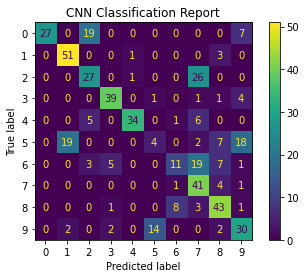

              precision    recall  f1-score   support

           0       1.00      0.51      0.67        53
           1       0.71      0.93      0.80        55
           2       0.50      0.50      0.50        54
           3       0.83      0.85      0.84        46
           4       0.94      0.74      0.83        46
           5       0.21      0.08      0.12        50
           6       0.52      0.24      0.33        46
           7       0.42      0.87      0.57        47
           8       0.64      0.77      0.70        56
           9       0.48      0.60      0.54        50

    accuracy                           0.61       503
   macro avg       0.63      0.61      0.59       503
weighted avg       0.63      0.61      0.59       503



In [ ]:
plot_classification_report(test_labs, test_pred_cnn, 'CNN Classification Report')

**CNN Model:** Using 1D Convolutional Classifier we get around 61% accuracy on the test set. Also, looking at the train set accuracy we see that the overfitting has reduces a lot and we got 83.4% accuracy. We see this small increase from the previous RNN model we created.

Looking at inidvidual class precision we see class 1 gets a perfect precision. This is also visible from the confusion matrix where we see there isn't a case where we predict 1 and it is wrong prediction. But this does not mean overall 1 is always predicted perfectly. As 1 has a rather bad recall value. This means samples with label 1 are often predicted badly. 

Further Looking at inidvidual class recall we see class 7 again gets a very high precision. This is also visible from the confusion matrix where we see samples belonging to class 7 are predicted correctly. But this does not mean overall 7 is always predicted perfectly. As 7 has a rather bad precision value. This means many samples with different label values are often predicted as belonging to class 7. 

Overall, looking at the F1 score we see class 0, 1, 3, 4, and 8 give a good and comparable performance.

#### TSNE

In [ ]:
def predict_dl_last(model, dataloader):
    preds, labels = [], []
    model.eval()
    for (mel, label) in dataloader:
        mel, label = mel.to(device), label.to(device)
        preds.extend(model(mel).cpu().detach().numpy())
        labels.extend(label.tolist())
    return np.array(preds), np.array(labels)

In [ ]:
# Evaluate on test set
from sklearn.calibration import CalibratedClassifierCV
calibrator = CalibratedClassifierCV(clf_sgd, cv='prefit')
model_sgd = calibrator.fit(x_train, y_train)

test_pred_sgd_last = model_sgd.predict_proba(x_test)
test_pred_rnn_last, test_labs = predict_dl_last(rnn_model, test_dl)
test_pred_cnn_last, test_labs = predict_dl_last(cnn_model, test_dl)

In [ ]:
tsne = TSNE(n_components=2)
test_tsne = tsne.fit_transform(x_test)
test_pred_sgd_tsne = tsne.fit_transform(np.array(test_pred_sgd_last))
test_pred_rnn_tsne = tsne.fit_transform(np.array(test_pred_rnn_last))
test_pred_cnn_tsne = tsne.fit_transform(np.array(test_pred_cnn_last))

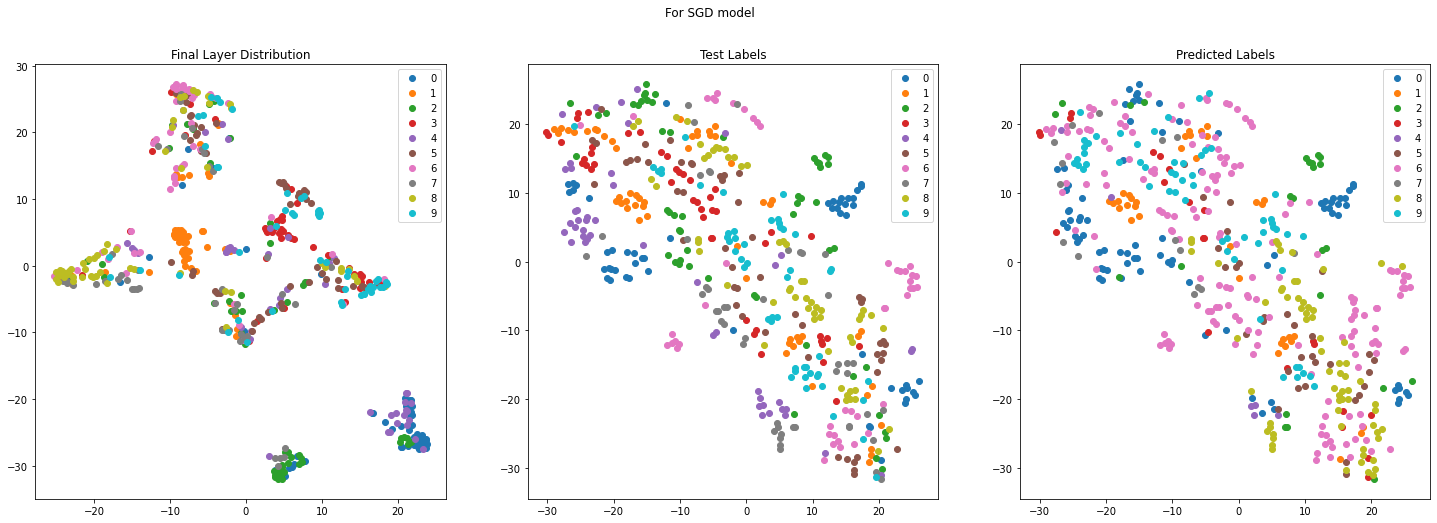

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,8))
fig.suptitle('For SGD model')
test_pred_sgd = np.array(test_pred_sgd)
for i in range(10):
    ax1.scatter(test_pred_sgd_tsne[y_test == i, 0], test_pred_sgd_tsne[y_test == i, 1], label=i)
    ax2.scatter(test_tsne[y_test == i, 0], test_tsne[y_test == i, 1], label=i)
    ax3.scatter(test_tsne[test_pred_sgd == i, 0], test_tsne[test_pred_sgd == i, 1], label=i)

# apply legend()
ax1.legend()
ax2.legend()
ax3.legend()
ax1.title.set_text('Final Layer Distribution')
ax2.title.set_text('Test Labels')
ax3.title.set_text('Predicted Labels')

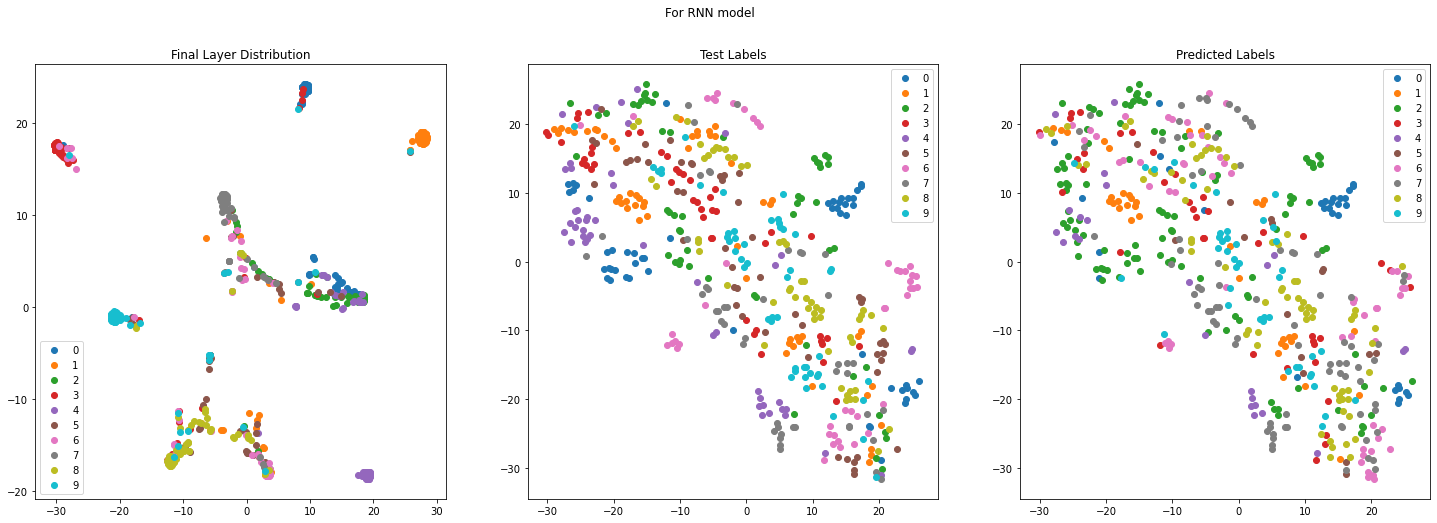

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,8))
fig.suptitle('For RNN model')
test_pred_rnn = np.array(test_pred_rnn)
for i in range(10):
    ax1.scatter(test_pred_rnn_tsne[y_test == i, 0], test_pred_rnn_tsne[y_test == i, 1], label=i)
    ax2.scatter(test_tsne[y_test == i, 0], test_tsne[y_test == i, 1], label=i)
    ax3.scatter(test_tsne[test_pred_rnn == i, 0], test_tsne[test_pred_rnn == i, 1], label=i)

# apply legend()
ax1.legend()
ax2.legend()
ax3.legend()
ax1.title.set_text('Final Layer Distribution')
ax2.title.set_text('Test Labels')
ax3.title.set_text('Predicted Labels')

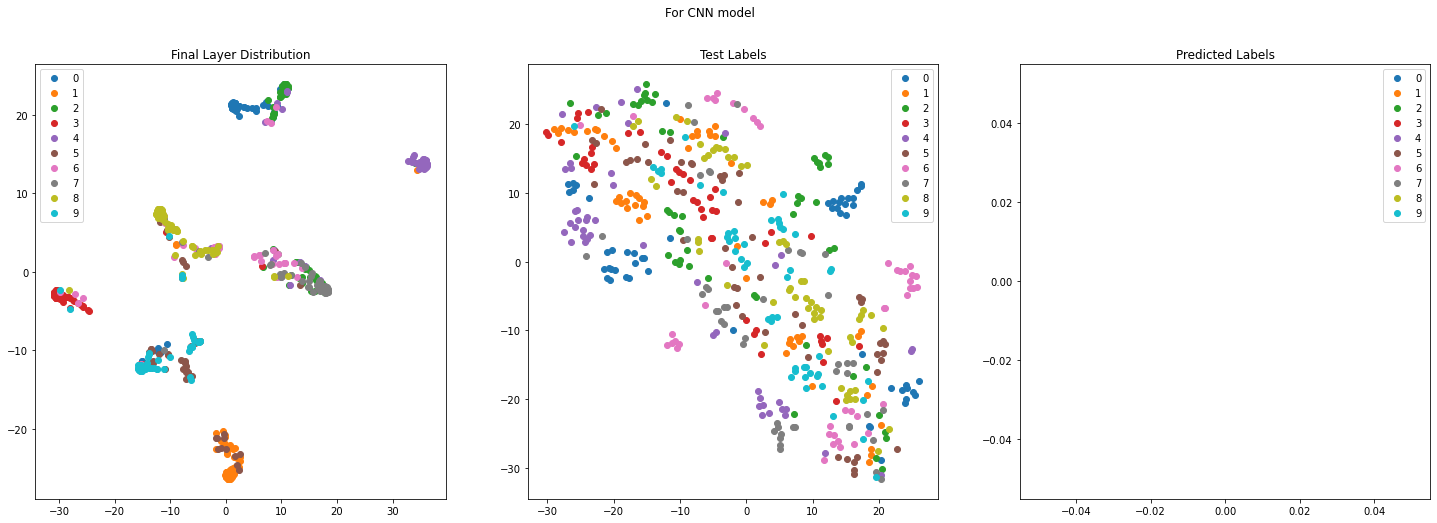

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,8))
fig.suptitle('For CNN model')
test_pred_rnn = np.array(test_pred_rnn)
for i in range(10):
    ax1.scatter(test_pred_cnn_tsne[y_test == i, 0], test_pred_cnn_tsne[y_test == i, 1], label=i)
    ax2.scatter(test_tsne[y_test == i, 0], test_tsne[y_test == i, 1], label=i)
    ax3.scatter(test_tsne[test_pred_cnn == i, 0], test_tsne[test_pred_cnn == i, 1], label=i)

# apply legend()
ax1.legend()
ax2.legend()
ax3.legend()
ax1.title.set_text('Final Layer Distribution')
ax2.title.set_text('Test Labels')
ax3.title.set_text('Predicted Labels')

Both Classify Correctly 0.4870775347912525
Only CNN Classify Correctly 0.12326043737574553
Only RNN Classify Correctly 0.10536779324055666
Neither Classify Correctly 0.28429423459244535


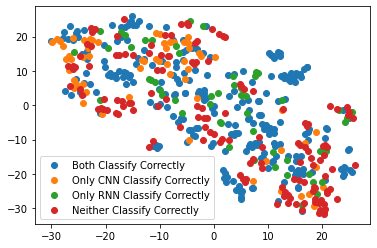

In [ ]:
correct_pred_cnn = y_test == test_pred_cnn
correct_pred_rnn = y_test == test_pred_rnn
correct_pred_rnn_cnn = correct_pred_rnn.astype(int)

for i in range(len(correct_pred_rnn_cnn)):
    if correct_pred_cnn[i] == 1 and correct_pred_rnn[i] == 1:
        correct_pred_rnn_cnn[i] = 0
    elif correct_pred_cnn[i] == 1 and correct_pred_rnn[i] == 0:
        correct_pred_rnn_cnn[i] = 1
    elif correct_pred_cnn[i] == 0 and correct_pred_rnn[i] == 1:
        correct_pred_rnn_cnn[i] = 2
    elif correct_pred_cnn[i] == 0 and correct_pred_rnn[i] == 0:
        correct_pred_rnn_cnn[i] = 3
plt.scatter(test_tsne[correct_pred_rnn_cnn == 0, 0], test_tsne[correct_pred_rnn_cnn == 0, 1], label='Both Classify Correctly')
plt.scatter(test_tsne[correct_pred_rnn_cnn == 1, 0], test_tsne[correct_pred_rnn_cnn == 1, 1], label='Only CNN Classify Correctly')
plt.scatter(test_tsne[correct_pred_rnn_cnn == 2, 0], test_tsne[correct_pred_rnn_cnn == 2, 1], label='Only RNN Classify Correctly')
plt.scatter(test_tsne[correct_pred_rnn_cnn == 3, 0], test_tsne[correct_pred_rnn_cnn == 3, 1], label='Neither Classify Correctly')
plt.legend()
print('Both Classify Correctly ' +  str(sum(correct_pred_rnn_cnn == 0)/len(correct_pred_rnn_cnn)))
print('Only CNN Classify Correctly ' +  str(sum(correct_pred_rnn_cnn == 1)/len(correct_pred_rnn_cnn)))
print('Only RNN Classify Correctly ' +  str(sum(correct_pred_rnn_cnn == 2)/len(correct_pred_rnn_cnn)))
print('Neither Classify Correctly ' +  str(sum(correct_pred_rnn_cnn == 3)/len(correct_pred_rnn_cnn)))

**Comparing the CNN and RNN models:** We see from the plot above that around 50% samples are classified correctly by both the models, while around 30% samples are classified incorrectly by both the samples. This leaves around 20% samples which are misclassified by only one of these models 

#### Bootstrap

In [ ]:
# https://github.com/rtmdrr/testSignificanceNLP/blob/master/testSignificance.py
def Bootstrap(model, sdr_df, dataset_type, model_acc, base_acc, n, R):
    r = 0
    delta_orig = model_acc - base_acc
    for x in range(R):
        samples = np.random.randint(0,n,n) #which samples to add to the subsample with repetitions
        temp_ds = SDRDataset(sdr_df, dataset_type, samples)
        temp_dl = DataLoader(temp_ds, batch_size=1, shuffle=False)
        temp_preds, temp_labels = predict_dl(model, temp_dl)
        temp_acc = accuracy_score(np.array(temp_labels), np.array(temp_preds))
        
        delta = temp_acc - base_acc
        if (delta > 2 * delta_orig):
            r = r + 1
            print("here")
        if not x % 100:
            df = open('Bootstrap_output.txt','w')
            df.write(str((x, r)))
            df.write('\n')
            df.close()
    pval = float(r)/(R)
    return pval

In [ ]:
R = 10000 # Recommended Use 1000000
sgd_acc = accuracy_score(np.array(y_test), np.array(test_pred_sgd))
rnn_acc = accuracy_score(np.array(y_test), np.array(test_pred_rnn))
cnn_acc = accuracy_score(np.array(y_test), np.array(test_pred_cnn))
pval = Bootstrap(rnn_model, sdr_df, dataset_type='TEST', model_acc=cnn_acc, base_acc=sgd_acc, n=sum(sdr_df.split == 'TEST'), R=R)

In [ ]:
with open('Bootstrap_output.txt') as f:
    lines = f.readlines()
num_iters, pval = lines[0][1:-2].split(', ')

In [ ]:
if (float(pval) <= 0.05):
    print("\nTest result is significant with p-value: {}".format(pval))
else:
    print("\nTest result is not significant with p-value: {}".format(pval))


Test result is significant with p-value: 0


## Task III (Open Ended)
1. Consider the case where we have speech data from a single speaker (e.g., george). Train your models on this subset of the data. What do you observe? How does this affect the model performance? 

2. Even though a model is trained on a single speaker, we would like the model to generalizes to any speaker. To this end, one can use data augmentation techniques to artificially create more samples for each class. Some of these augmentations can be applied on the spectrogram (e.g., SpecAugment https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html), and other can be applied on the raw waveform before creating the spectrogram such as pitch manipulation (https://github.com/facebookresearch/WavAugment). Explore the effect of one type of augmentation from each type. Report your observation and anaylze the confusion matrices.

3. Data augmentation techniques create different "views" of each training sample in a stochastic or determinstic approach. One can leaverage speech data augmentation to create views for training a neural network in a contrastive learning setting with margin-based objective function (for more info, read http://proceedings.mlr.press/v130/al-tahan21a/al-tahan21a.pdf). Implement at least one model using a contrastive loss based on different views of the training samples. Does this model improve over the model without contrastive learning? Report and discuss your observations. 

For more information on the contrastive learning framework, you can refer to this paper
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9226466

In [ ]:
# Filtering train data with only one speaker - george 
indices = []

for i in range(len(train_ds.files)):
    if "george" in train_ds.files[i]:
      indices.append(i)

train_ds.files =  [train_ds.files[i] for i in indices]
train_ds.labels =  [train_ds.labels[i] for i in indices]

# datalodaer
train_dl_single_speaker = DataLoader(train_ds, batch_size=1, shuffle=True)

In [ ]:
# Instantiate the model with hyperparameters
rnn_model = RNNModel(input_size=13, hidden_dim=256, output_size=10).to(device)

# Define hyperparameters
n_epochs = 30
lr = 0.001

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [ ]:
# train the model
train(model=rnn_model, train_dl=train_dl_single_speaker, val_dl=dev_dl, criterion=criterion, optimizer=optimizer, epochs=n_epochs, checkpoint_name="rnn_single_speaker.pt")

Epoch [1/30] Loss: 2.2991 Val. Acc: 0.2394 Best Model Acc: 0.2394
Epoch [2/30] Loss: 2.1596 Val. Acc: 0.2918 Best Model Acc: 0.2918
Epoch [3/30] Loss: 1.9298 Val. Acc: 0.3139 Best Model Acc: 0.3139
Epoch [4/30] Loss: 1.7809 Val. Acc: 0.3984 Best Model Acc: 0.3984
Epoch [5/30] Loss: 1.6961 Val. Acc: 0.4286 Best Model Acc: 0.4286
Epoch [6/30] Loss: 1.6567 Val. Acc: 0.4105 Best Model Acc: 0.4286
Epoch [7/30] Loss: 1.6255 Val. Acc: 0.4527 Best Model Acc: 0.4527
Epoch [8/30] Loss: 1.5949 Val. Acc: 0.4185 Best Model Acc: 0.4527
Epoch [9/30] Loss: 1.5723 Val. Acc: 0.4608 Best Model Acc: 0.4608
Epoch [10/30] Loss: 1.5536 Val. Acc: 0.4708 Best Model Acc: 0.4708
Epoch [11/30] Loss: 1.5398 Val. Acc: 0.4930 Best Model Acc: 0.4930
Epoch [12/30] Loss: 1.5292 Val. Acc: 0.4588 Best Model Acc: 0.4930
Epoch [13/30] Loss: 1.5213 Val. Acc: 0.4648 Best Model Acc: 0.4930
Epoch [14/30] Loss: 1.5132 Val. Acc: 0.4688 Best Model Acc: 0.4930
Epoch [15/30] Loss: 1.5057 Val. Acc: 0.4829 Best Model Acc: 0.4930
Epoc

In [ ]:
# Load the best model from the checkpoint saved by early stopping
rnn_model.load_state_dict(torch.load('rnn_single_speaker_best.pt', map_location=device))

# Evaluate on train & test set
train_pred_rnn, train_labs = predict_dl(rnn_model, train_dl)
test_pred_rnn, test_labs = predict_dl(rnn_model, test_dl)

print("Train Accuracy for RNN with single speaker:", accuracy_score(np.array(train_labs), np.array(train_pred_rnn)))
print("Test Accuracy for RNN with single speaker:", accuracy_score(np.array(test_labs), np.array(test_pred_rnn)))

Train Accuracy for RNN with single speaker: 0.976
Test Accuracy for RNN with single speaker: 0.4691848906560636


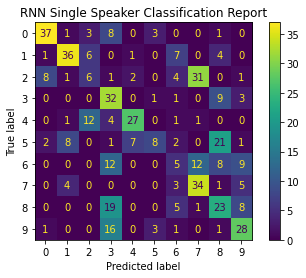

              precision    recall  f1-score   support

           0       0.76      0.70      0.73        53
           1       0.71      0.65      0.68        55
           2       0.22      0.11      0.15        54
           3       0.34      0.70      0.46        46
           4       0.73      0.59      0.65        46
           5       0.53      0.16      0.25        50
           6       0.17      0.11      0.13        46
           7       0.43      0.72      0.54        47
           8       0.34      0.41      0.37        56
           9       0.51      0.56      0.53        50

    accuracy                           0.47       503
   macro avg       0.47      0.47      0.45       503
weighted avg       0.48      0.47      0.45       503



In [ ]:
plot_classification_report(test_labs, test_pred_rnn, 'RNN Single Speaker Classification Report')

**RNN Single Speaker Model:** Using RNN Classifier we get around 46.9% accuracy on the test set. Also, looking at the train set accuracy we see high overfitting with 97.6% accuracy. We see this reduction from the previous model we created in Task 2. It is because the same model is not able to learn the feature mapping and patterns with limited amount of training data. Hence it is also not able to generalize well to unseen data.

Overall, looking at the F1 score we see class 0, 1 and 4 give a good performance.

#### Frequency Masking

In [ ]:
class SDRDatasetSingleSpeakerAug(Dataset):

  def __init__(self, sdr_df, dataset_type, speaker_name, mask, add_dim, transforms=[]):
    self.spec = []
    self.labels = []
    
    for index, row in sdr_df.iterrows():
      if row['split'] == dataset_type and row['speaker'] == speaker_name:
        x, sr = librosa.load(row['file'], sr=SAMPLING_RATE)
        melspec = extract_melspectrogram(x, sr, num_mels=13)
        
        # adding extra dimension for Time Masking spec augmentation
        if add_dim == True:
          melspec = melspec[np.newaxis, :]
        
        melspec_t = torch.from_numpy(melspec)
        melspec_aug = mask(melspec_t)
        spec_aug = melspec_aug.cpu().detach().numpy()
        
        # Removing extra dimension
        if add_dim == True:
          melspec = melspec[0, :, :]
          spec_aug = spec_aug[0, :, :]
        
        # saving original data
        self.spec.append(melspec)
        self.labels.append(row['label'])
        print(melspec)

        # saving augmented data
        self.spec.append(spec_aug)
        self.labels.append(row['label'])
        print(spec_aug)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return (self.spec[idx].transpose(1, 0), self.labels[idx])

In [ ]:
# Spec augmentation using Frequency Masking
masking = T.FrequencyMasking(freq_mask_param=30)

train_ds_freq_mask = SDRDatasetSingleSpeakerAug(sdr_df, 'TRAIN', 'george', masking, False)

# data loader
train_dl_freq_mask = DataLoader(train_ds_freq_mask, batch_size=1, shuffle=True)

rnn_model = RNNModel(input_size=13, hidden_dim=256, output_size=10).to(device)

In [ ]:
# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [ ]:
train(model=rnn_model, train_dl=train_dl_freq_mask, val_dl=dev_dl, criterion=criterion, optimizer=optimizer, epochs=n_epochs, checkpoint_name="rnn_freq_mask.pt")

Epoch [1/30] Loss: 2.2928 Val. Acc: 0.1710 Best Model Acc: 0.1710
Epoch [2/30] Loss: 2.1514 Val. Acc: 0.2757 Best Model Acc: 0.2757
Epoch [3/30] Loss: 2.0312 Val. Acc: 0.3360 Best Model Acc: 0.3360
Epoch [4/30] Loss: 1.9582 Val. Acc: 0.3682 Best Model Acc: 0.3682
Epoch [5/30] Loss: 1.9216 Val. Acc: 0.3944 Best Model Acc: 0.3944
Epoch [6/30] Loss: 1.8924 Val. Acc: 0.4024 Best Model Acc: 0.4024
Epoch [7/30] Loss: 1.8737 Val. Acc: 0.4346 Best Model Acc: 0.4346
Epoch [8/30] Loss: 1.8587 Val. Acc: 0.3883 Best Model Acc: 0.4346
Epoch [9/30] Loss: 1.8490 Val. Acc: 0.4004 Best Model Acc: 0.4346
Epoch [10/30] Loss: 1.8400 Val. Acc: 0.3863 Best Model Acc: 0.4346
Epoch [11/30] Loss: 1.8320 Val. Acc: 0.4346 Best Model Acc: 0.4346
Epoch [12/30] Loss: 1.8245 Val. Acc: 0.4507 Best Model Acc: 0.4507
Epoch [13/30] Loss: 1.8186 Val. Acc: 0.3924 Best Model Acc: 0.4507
Epoch [14/30] Loss: 1.8181 Val. Acc: 0.4366 Best Model Acc: 0.4507
Epoch [15/30] Loss: 1.8150 Val. Acc: 0.4447 Best Model Acc: 0.4507
Epoc

In [ ]:
# Load the best model from the checkpoint saved by early stopping
rnn_model.load_state_dict(torch.load('rnn_freq_mask_best.pt', map_location=device))

# Evaluate on train & test set
train_pred_rnn, train_labs = predict_dl(rnn_model, train_dl)
test_pred_rnn, test_labs = predict_dl(rnn_model, test_dl)

print("Train Accuracy (RNN) with single speaker and frequency masking spec augmentation:", accuracy_score(np.array(train_labs), np.array(train_pred_rnn)))
print("Test Accuracy (RNN) with single speaker and frequency masking spec augmentation:", accuracy_score(np.array(test_labs), np.array(test_pred_rnn)))

Train Accuracy (RNN) with single speaker and frequency masking spec augmentation: 0.992
Test Accuracy (RNN) with single speaker and frequency masking spec augmentation: 0.44532803180914515


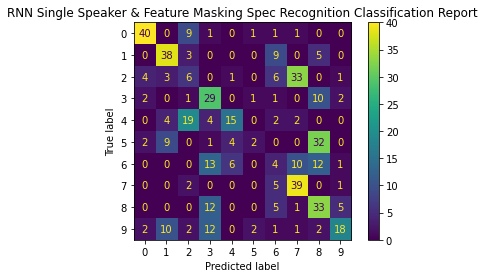

              precision    recall  f1-score   support

           0       0.80      0.75      0.78        53
           1       0.59      0.69      0.64        55
           2       0.14      0.11      0.12        54
           3       0.40      0.63      0.49        46
           4       0.58      0.33      0.42        46
           5       0.33      0.04      0.07        50
           6       0.12      0.09      0.10        46
           7       0.45      0.83      0.58        47
           8       0.35      0.59      0.44        56
           9       0.64      0.36      0.46        50

    accuracy                           0.45       503
   macro avg       0.44      0.44      0.41       503
weighted avg       0.44      0.45      0.41       503



In [ ]:
plot_classification_report(test_labs, test_pred_rnn, 'RNN Single Speaker & Feature Masking Spec Recognition Classification Report')

#### Time Masking

In [ ]:
# Spec augmentation using Time masking
masking = T.TimeMasking(time_mask_param=50)

train_ds_time_mask = SDRDatasetSingleSpeakerAug(sdr_df, 'TRAIN', 'george', masking, True)

train_dl_time_mask = DataLoader(train_ds_time_mask, batch_size=1, shuffle=True)

rnn_model = RNNModel(input_size=13, hidden_dim=256, output_size=10).to(device)

In [ ]:
# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [ ]:
train(model=rnn_model, train_dl=train_dl_freq_mask, val_dl=dev_dl, criterion=criterion, optimizer=optimizer, epochs=n_epochs, checkpoint_name="rnn_time_mask.pt")

Epoch [1/30] Loss: 2.2891 Val. Acc: 0.2072 Best Model Acc: 0.2072
Epoch [2/30] Loss: 2.1370 Val. Acc: 0.3018 Best Model Acc: 0.3018
Epoch [3/30] Loss: 2.0197 Val. Acc: 0.3421 Best Model Acc: 0.3421
Epoch [4/30] Loss: 1.9520 Val. Acc: 0.3763 Best Model Acc: 0.3763
Epoch [5/30] Loss: 1.9201 Val. Acc: 0.3823 Best Model Acc: 0.3823
Epoch [6/30] Loss: 1.8994 Val. Acc: 0.3783 Best Model Acc: 0.3823
Epoch [7/30] Loss: 1.8762 Val. Acc: 0.3863 Best Model Acc: 0.3863
Epoch [8/30] Loss: 1.8599 Val. Acc: 0.4044 Best Model Acc: 0.4044
Epoch [9/30] Loss: 1.8489 Val. Acc: 0.4064 Best Model Acc: 0.4064
Epoch [10/30] Loss: 1.8372 Val. Acc: 0.4044 Best Model Acc: 0.4064
Epoch [11/30] Loss: 1.8312 Val. Acc: 0.4366 Best Model Acc: 0.4366
Epoch [12/30] Loss: 1.8222 Val. Acc: 0.4487 Best Model Acc: 0.4487
Epoch [13/30] Loss: 1.8218 Val. Acc: 0.4386 Best Model Acc: 0.4487
Epoch [14/30] Loss: 1.8141 Val. Acc: 0.4145 Best Model Acc: 0.4487
Epoch [15/30] Loss: 1.8104 Val. Acc: 0.4567 Best Model Acc: 0.4567
Epoc

In [ ]:
# Load the best model from the checkpoint saved by early stopping
rnn_model.load_state_dict(torch.load('rnn_time_mask_best.pt', map_location=device))

# Evaluate on train & test set
train_pred_rnn, train_labs = predict_dl(rnn_model, train_dl)
test_pred_rnn, test_labs = predict_dl(rnn_model, test_dl)

print("Train Accuracy (RNN) with single speaker and time masking spec augmentation:", accuracy_score(np.array(train_labs), np.array(train_pred_rnn)))
print("Test Accuracy (RNN) with single speaker and time masking spec augmentation:", accuracy_score(np.array(test_labs), np.array(test_pred_rnn)))

Train Accuracy (RNN) with single speaker and time masking spec augmentation: 0.992
Test Accuracy (RNN) with single speaker and time masking spec augmentation: 0.4592445328031809


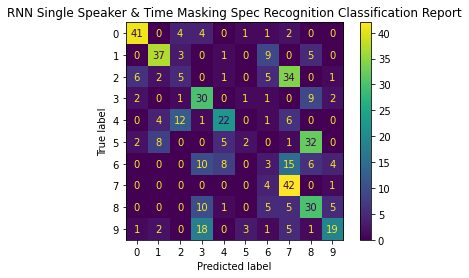

              precision    recall  f1-score   support

           0       0.79      0.77      0.78        53
           1       0.70      0.67      0.69        55
           2       0.20      0.09      0.13        54
           3       0.41      0.65      0.50        46
           4       0.58      0.48      0.52        46
           5       0.29      0.04      0.07        50
           6       0.10      0.07      0.08        46
           7       0.38      0.89      0.54        47
           8       0.36      0.54      0.43        56
           9       0.59      0.38      0.46        50

    accuracy                           0.46       503
   macro avg       0.44      0.46      0.42       503
weighted avg       0.44      0.46      0.42       503



In [ ]:
plot_classification_report(test_labs, test_pred_rnn, 'RNN Single Speaker & Time Masking Spec Recognition Classification Report')

#### Wave Augmentation

In [ ]:
!apt-get install libsox-fmt-all libsox-dev sox > /dev/null
! python -m pip install torchaudio > /dev/null
! python -m pip install git+https://github.com/facebookresearch/WavAugment.git > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/WavAugment.git /tmp/pip-req-build-ig0dtwr2


In [ ]:
!pip install ffmpeg-python > /dev/null

In [ ]:
import augment
import torchaudio

In [ ]:
class SDRDatasetWav(Dataset):

  def __init__(self, sdr_df, dataset_type, speaker_name):
    sdr_df_data_type = sdr_df[sdr_df.split == dataset_type] 
    self.files = sdr_df_data_type.file[sdr_df_data_type.speaker == speaker_name].to_numpy()
    self.labels = sdr_df_data_type.label[sdr_df_data_type.speaker == speaker_name].to_numpy()

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    x, sr = torchaudio.load(self.files[idx])
    
    random_number = random.randint(1, 5)
    if random_number == 1:
        y = augment.EffectChain().pitch(-200).rate(sr).apply(x, src_info={'rate': sr})
    elif random_number == 2:
        y = augment.EffectChain().pitch(200).rate(sr).apply(x, src_info={'rate': sr})
    elif random_number == 3:
        y = augment.EffectChain().reverb(50, 50, 50).channels(1).apply(x, src_info={'rate': sr})
    elif random_number == 4:
        noise_generator = lambda: torch.zeros_like(x).uniform_()
        y = augment.EffectChain().additive_noise(noise_generator, snr=15).apply(x, src_info={'rate': sr})
    elif random_number == 5:
        y = x
    melspec = extract_melspectrogram(y.cpu().detach().numpy()[0], sr, num_mels=13)
    return (melspec.transpose(1, 0), self.labels[idx])

In [ ]:
train_ds  = SDRDatasetWav(sdr_df, 'TRAIN', 'george')
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

In [ ]:
# Instantiate the model with hyperparameters
rnn_model = RNNModel(input_size=13, hidden_dim=256, output_size=10).to(device)

# Define hyperparameters
n_epochs = 30
lr = 0.001

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [ ]:
train(model=rnn_model, train_dl=train_dl, val_dl=dev_dl, criterion=criterion, optimizer=optimizer, epochs=n_epochs, checkpoint_name="rnn_wav.pt")

Epoch [1/30] Loss: 2.2954 Val. Acc: 0.2032 Best Model Acc: 0.2032
Epoch [2/30] Loss: 2.1559 Val. Acc: 0.2978 Best Model Acc: 0.2978
Epoch [3/30] Loss: 1.9886 Val. Acc: 0.3139 Best Model Acc: 0.3139
Epoch [4/30] Loss: 1.8803 Val. Acc: 0.3742 Best Model Acc: 0.3742
Epoch [5/30] Loss: 1.7858 Val. Acc: 0.4044 Best Model Acc: 0.4044
Epoch [6/30] Loss: 1.7423 Val. Acc: 0.4145 Best Model Acc: 0.4145
Epoch [7/30] Loss: 1.7058 Val. Acc: 0.4386 Best Model Acc: 0.4386
Epoch [8/30] Loss: 1.6827 Val. Acc: 0.4507 Best Model Acc: 0.4507
Epoch [9/30] Loss: 1.6639 Val. Acc: 0.3843 Best Model Acc: 0.4507
Epoch [10/30] Loss: 1.6498 Val. Acc: 0.4427 Best Model Acc: 0.4507
Epoch [11/30] Loss: 1.6232 Val. Acc: 0.4205 Best Model Acc: 0.4507
Epoch [12/30] Loss: 1.6066 Val. Acc: 0.4507 Best Model Acc: 0.4507
Epoch [13/30] Loss: 1.5972 Val. Acc: 0.4527 Best Model Acc: 0.4527
Epoch [14/30] Loss: 1.5933 Val. Acc: 0.4648 Best Model Acc: 0.4648
Epoch [15/30] Loss: 1.5770 Val. Acc: 0.4628 Best Model Acc: 0.4648
Epoc

In [ ]:
# Load the best model from the checkpoint saved by early stopping
rnn_model.load_state_dict(torch.load('rnn_wav_best.pt', map_location=device))

# Evaluate on train & test set
train_pred_rnn, train_labs = predict_dl(rnn_model, train_dl)
test_pred_rnn, test_labs = predict_dl(rnn_model, test_dl)

print("Train Accuracy (RNN) with single speaker and Wav augmentation:", accuracy_score(np.array(train_labs), np.array(train_pred_rnn)))
print("Test Accuracy (RNN) with single speaker and Wav augmentation:", accuracy_score(np.array(test_labs), np.array(test_pred_rnn)))

Train Accuracy (RNN) with single speaker and Wav augmentation: 0.974
Test Accuracy (RNN) with single speaker and Wav augmentation: 0.4671968190854871


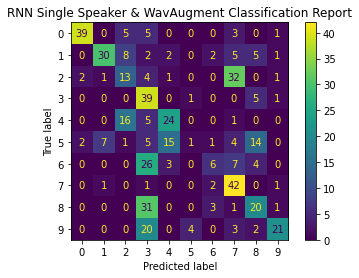

              precision    recall  f1-score   support

           0       0.91      0.74      0.81        53
           1       0.77      0.55      0.64        55
           2       0.30      0.24      0.27        54
           3       0.28      0.85      0.42        46
           4       0.53      0.52      0.53        46
           5       0.17      0.02      0.04        50
           6       0.43      0.13      0.20        46
           7       0.43      0.89      0.58        47
           8       0.40      0.36      0.38        56
           9       0.78      0.42      0.55        50

    accuracy                           0.47       503
   macro avg       0.50      0.47      0.44       503
weighted avg       0.50      0.47      0.44       503



In [ ]:
plot_classification_report(test_labs, test_pred_rnn, 'RNN Single Speaker & WavAugment Classification Report')

#### Contrastive Loss

In [ ]:
def train_con(model, train_dl, val_dl, criterion, optimizer, epochs=5, early_stop=True, patience=5, checkpoint_name="checkpoint.pt"):
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        epoch_loss = []
        for i, (mel, label) in enumerate(train_dl):
            mel, label = mel.to(device), label.to(device)
            
            outputs = model(mel)
            loss = criterion(outputs, label)

            epoch_loss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss_mean = sum(epoch_loss)/len(epoch_loss)

        preds, labs = predict_dl_con(model, val_dl)
        acc = accuracy_score(preds, labs)
        
        if acc > best_val_acc:
            best_val_acc = acc
            torch.save(model.state_dict(), checkpoint_name)
        
        print("Epoch [{}/{}] Loss: {:.4f} Val. Acc: {:.4f} Best Model Acc: {:.4f}".format(epoch+1, epochs, epoch_loss_mean, acc, best_val_acc))

def predict_dl_con(model, dataloader):
    preds, labels = [], []
    model.eval()
    for (mel, label) in dataloader:
        mel, label = mel.to(device), label.to(device)
        out = model(mel)
        out = torch.mean(out, dim=1)
        out = F.softmax(out, dim=-1)
        preds.extend(torch.argmax(out, dim=1).tolist())
        labels.extend(label.tolist())
        # print(labels)
    return preds, labels

In [ ]:
# https://github.com/HobbitLong/SupContrast
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)
        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))
        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [ ]:
class RNNModelCon(nn.Module):

  def __init__(self, input_size, hidden_dim, output_size=10, n_layers=1):
    super(RNNModelCon, self).__init__()
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    self.lstm = nn.LSTM(input_size, hidden_dim)
    self.fc = nn.Linear(hidden_dim, output_size)

  def forward(self, x, testhid_prev=None, ctx_prev=None):
    batch_size = x.size(0)
    hidden, context = self.init_hidden(batch_size, x)
    out, (hid, ctx) = self.lstm(x, (hidden, context))
    out = self.fc(out)
    # print(out.shape)
    # out = torch.mean(out, dim=1)
    # out = F.softmax(out, dim=-1)
    return out

  def init_hidden(self, batch_size, x):
    hidden  = torch.zeros(self.n_layers, x.shape[1], self.hidden_dim).to(device)
    context = torch.zeros(self.n_layers, x.shape[1], self.hidden_dim).to(device)
    return hidden, context

In [ ]:
# Instantiate the model with hyperparameters
rnn_model = RNNModelCon(input_size=13, hidden_dim=256, output_size=10).to(device)

# Define hyperparameters
n_epochs = 30
lr =  0.001
temp = 0.1

criterion = SupConLoss(temperature=temp)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [ ]:
train_con(model=rnn_model, train_dl=train_dl, val_dl=dev_dl, criterion=criterion, optimizer=optimizer, epochs=n_epochs, checkpoint_name="rnn_con_lrn.pt")